In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
from colicoords import iter_subplots
from colicoords.cnn.unet import get_unet_256
from colicoords.cnn.preprocess import DefaultImgSequence, resize_stack
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import tifffile
import os
import numpy as np

100 brightfield images of each dataset were manually annotated (segmented) and will be combined to train a neural network to segment the rest of the brightfield images.

In [3]:
data_dir = r'.'

Loading Cy3B images:

In [4]:
binary_cy3b = tifffile.imread(os.path.join(data_dir, 'Cy3B_NHS', 'Binary_annotated.tif'))
brightfield_cy3b = tifffile.imread(os.path.join(data_dir, 'Cy3B_NHS', 'Bf_corrected.tif'))[:100]
binary_cy3b.shape, brightfield_cy3b.shape

((100, 512, 512), (100, 512, 512))

Loading eGFP images:

In [5]:
binary_egfp = tifffile.imread(os.path.join(data_dir, 'eGFP', 'Binary_annotated.tif'))
brightfield_egfp = tifffile.imread(os.path.join(data_dir, 'eGFP', 'Bf_corrected.tif'))[:100]
binary_egfp.shape, brightfield_egfp.shape

((100, 512, 512), (100, 512, 512))

We can use ``iter_subplots`` to quickly browse the images and check if they're properly segemented.

<IPython.core.display.Javascript object>


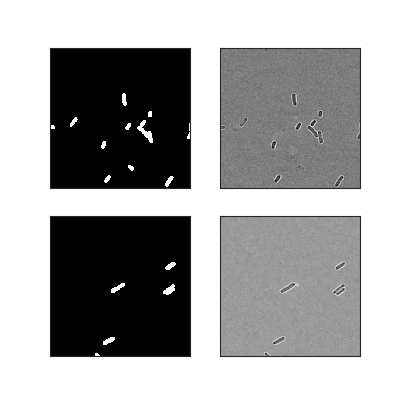

In [6]:
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.labelleft'] = False

fig, axes = iter_subplots(2, 2, figsize=(4,4))
axes[0, 0].iter_imshow(binary_cy3b, cmap='gray')
axes[0, 1].iter_imshow(brightfield_cy3b, cmap='gray')
axes[1, 0].iter_imshow(binary_egfp, cmap='gray')
axes[1, 1].iter_imshow(brightfield_egfp, cmap='gray')
fig.display()

Combining both stacks:

In [7]:
binary = np.concatenate([binary_egfp, binary_cy3b])
brightfield = np.concatenate([brightfield_egfp, brightfield_cy3b])
binary.shape, brightfield.shape

((200, 512, 512), (200, 512, 512))

<IPython.core.display.Javascript object>


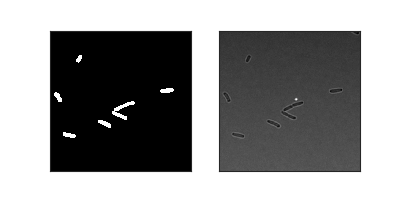

In [8]:
fig, axes = iter_subplots(1, 2, figsize=(4,2))
axes[0].iter_imshow(binary, cmap='gray')
axes[1].iter_imshow(brightfield, cmap='gray')
fig.display()

Resizing the stacks to 256x256 to preserve memory:

In [9]:
binary_resized = resize_stack((binary > 0).astype(int), 0.5, img_type='binary')
brightfield_resized = resize_stack(brightfield, 0.5)
binary_resized.shape, binary_resized.shape

((200, 256, 256), (200, 256, 256))

The ``DefualtImgSequence`` used to augment the data and to normalize the images. Then the sequence is split into the training and validation datasets.

In [10]:
isq = DefaultImgSequence(brightfield_resized, binary_resized)
vsq, tsq = isq.val_split(1/8., random=True)
vsq.shuffle(), tsq.shuffle()
len(vsq), len(tsq)

Warning, index out of bounds, set to last element


(25, 175)

In [16]:
os.mkdir(os.path.join(data_dir, 'wts')) if not os.path.exists(os.path.join(data_dir, 'wts')) else None
os.mkdir(os.path.join(data_dir, 'logs')) if not os.path.exists(os.path.join(data_dir, 'logs')) else None

Finally, we train the model. The modelcheckpoint is used to save the weights after each epoch and the tensorboard callback generate logs file which can be used to evauluate training performance. 

In [ ]:
tf.global_variables_initializer()
model = get_unet_256(input_shape=(256, 256, 1))
cp = ModelCheckpoint(os.path.join(data_dir, 'wts', 'wts_bf_{epoch:02d}-{val_loss:.6f}.h5'), monitor='val_loss', 
                     save_weights_only=True, verbose=1, mode='min')
tb = TensorBoard(log_dir=os.path.join(data_dir, 'logs'))
model.fit_generator(tsq, steps_per_epoch=len(tsq), epochs=50, validation_data=vsq, callbacks=[cp, tb])